# About
- Web site : https://sirius.inserjeunes.beta.gouv.fr/verbatims/moderation
- Github : https://github.com/mission-apprentissage/sirius-ml
- Author : Do HUYNH ([@huynhdoo](https://github.com/huynhdoo))
- Date : 2025.03
- Licence : MIT



## Règles de modération
https://sunrise-waitress-5d6.notion.site/Mod-ration-d6dc1c3f74e149458f3b2473d416dfd7

- En attente : Verbatim en attente de traitement
- VALIDATED : Peut être exposé
- TO_FIX : Aurait un intérêt, mais ne peut pas être exposé en l’état : contient des informations déplacées, sensibles, perso…
- ALERT : Ne peut être exposé, mais aurait un intérêt pour le CFA : situation critique mise en évidence.
- REJECTED : Commentaire invalidé, ne sera pas exposé.
- GEM : Commentaire particulièrement intéressant (positif ou non)

## Régles d'alertes
- Est-ce que le texte contient des insultes ?
- Est-ce que le texte contient des données personnelles ?

## Règles de correction
- Correction des fautes d'orthographe et grammaire
- Remplacement des prénoms et noms de familles par des pronoms personnels

# Dataset

In [ ]:
%%writefile requirements.txt
scikit-learn==1.5.1
pandas==2.2.2
numpy==1.26.4
transformers==4.44.1
torch==2.4.0
skops==0.10.0
joblib==1.4.2
sentence-transformers==3.1.1
requests==2.32.3
datasets==3.0.0
huggingface_hub>=0.22.0

Writing requirements.txt


In [ ]:
%%capture
!pip install -r requirements.txt

In [ ]:
from google.colab import userdata
import os
os.environ['SIRIUS_DB_API'] = userdata.get('SIRIUS_DB_API')
os.environ['SIRIUS_HF_TOKEN'] = userdata.get('SIRIUS_HF')
os.environ['table'] = "verbatims"
os.environ['repo'] = "apprentissage-sirius/verbatims"

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import requests
from datasets import Dataset, load_dataset
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm
from multiprocessing import cpu_count
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

class Datas():
    def __init__(self, api='', hf='', encoder_name='Lajavaness/sentence-camembert-large'):
        # Load embedding model
        # encoder_name = "almanach/camembertav2-base"
        # self.encoder = AutoTokenizer.from_pretrained(encoder_name)
        self.encoder = SentenceTransformer(encoder_name)
        print(f"[Done] Loaded encoder {encoder_name}: {self.encoder.max_seq_length} input size.")
        # print(f"[Done] Loaded encoder {encoder_name}: {self.encoder.model_max_length} input size.")

        # Initialize dataset
        self.api = api
        self.hf = hf
        self.datas = None
        print("[Done] Dataset initialized.")

    #################
    # Dataset methods
    #################
    def read(self, table=''):
        payload = dict(
            table = table
        )
        resp = requests.post(url=self.api, json=payload)
        data = resp.json()
        self.datas = pd.DataFrame(data['datapoints'], columns=data['cols'])
        print(f"[Done] Dataset loaded.")

    def prepare(self, table=''):
        if table == 'verbatims':
            cols = ['question_key', 'content', 'status', 'created_at']
            dataset = self.datas[cols].copy()
            dataset['text'] = dataset['question_key'] + ': ' + dataset['content']
            dataset['created_at'] = pd.to_datetime(dataset['created_at'], format='ISO8601')
            dataset['year'] = dataset['created_at'].dt.year
            dataset['month'] = dataset['created_at'].dt.month
            dataset['day'] = dataset['created_at'].dt.day
            dataset.drop(columns=['question_key', 'content', 'created_at'], inplace=True)
            dataset.drop_duplicates(inplace=True)
            dataset.reset_index(drop=True, inplace=True)
            self.datas = dataset
            print(f"[Done] Dataset prepared.")
        else:
            print(f"[Error] Unknown specific format rules for {table} dataset.")

    def encode(self, text_col):
        # Create embeddings
        texts = self.datas[text_col].tolist()
        print(f"[Pending] Encoding dataset...")
        try:
            embeddings = self.encoder.encode(texts, device="cuda", show_progress_bar=True)
        except:
            nb_cpu = min(cpu_count(), 8)
            embeddings = Parallel(n_jobs=nb_cpu - 1, prefer="threads")(delayed(self.encoder.encode)(i) for i in tqdm(texts, desc=f"Encoding on {nb_cpu} CPU"))

        emb_df = pd.DataFrame(embeddings).fillna(0)
        emb_df.columns = [f"emb_{i+1}" for i in range(emb_df.shape[1])]
        self.datas = pd.concat([self.datas, emb_df], axis=1)
        print(f"[Done] Embeddings ready.")

    def save(self, repo):
        dataset = Dataset.from_pandas(self.datas)
        dataset.push_to_hub(repo, private=True, token=self.hf)
        print(f"[Done] Dataset exported to: {repo}.")

    def load(self, repo):
        self.datas = load_dataset(repo, token=self.hf, split="all").to_pandas()
        print(f"[Done] Dataset loaded from {repo}: {self.datas.shape}")

# Load & encode

Modèle : CamemBERT(a)-v2

Date : 2024.11

Paper : https://arxiv.org/abs/2411.08868


In [ ]:
import os

print(f"SIRIUS training job started.")

# Instanciate dataset
datas = Datas(api=os.environ['SIRIUS_DB_API'],
              hf=os.environ['SIRIUS_HF_TOKEN'],
              encoder_name='almanach/camembertav2-base') #https://huggingface.co/almanach/camembertav2-base

# Run training
table = os.environ['table']
repo = os.environ['repo']

# Extract dataset from table
datas.read(table=table)
datas.prepare(table=table)
datas.encode(text_col='text')

# Export dataset
datas.save(repo=repo)

print(f"SIRIUS training job ended.")

SIRIUS training job started.


[Done] Loaded encoder almanach/camembertav2-base: 1024 input size.
[Done] Dataset initialized.
[Done] Dataset loaded.
[Done] Dataset prepared.
[Pending] Encoding dataset...


Batches:   0%|          | 0/400 [00:00<?, ?it/s]

[Done] Embeddings ready.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

No files have been modified since last commit. Skipping to prevent empty commit.


[Done] Dataset exported to: apprentissage-sirius/verbatims.
SIRIUS training job ended.


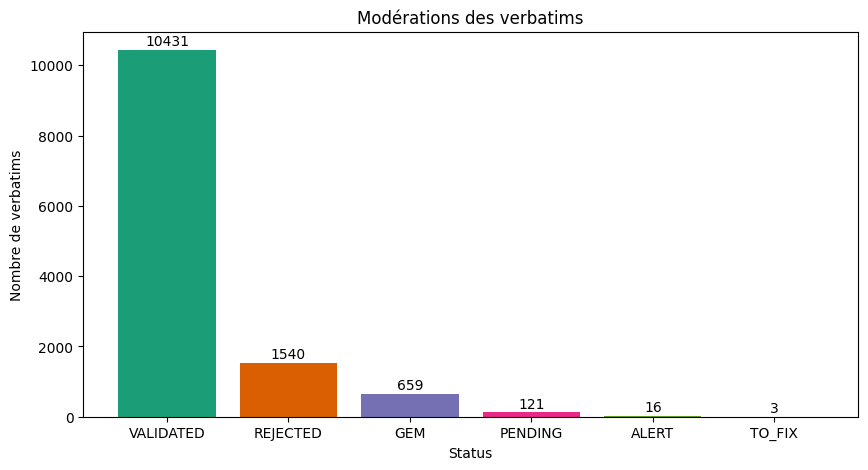

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(datas.datas['status'].value_counts().index, datas.datas['status'].value_counts(), align='center', color=sns.palettes.mpl_palette('Dark2'))
plt.title("Modérations des verbatims")
plt.xlabel("Status")
plt.ylabel('Nombre de verbatims')
plt.bar_label(bars, padding=1)
plt.show()

In [ ]:
datas.datas

,status,text,year,month,day,emb_1,emb_2,emb_3,emb_4,emb_5,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,emb_768
0,VALIDATED,commentTrouverEntrepriseAutre: à préparer mes ...,2023,4,25,0.577967,0.145891,0.046919,-0.189657,-0.092748,...,-0.180801,0.153595,-0.022789,0.106385,-0.057768,0.080422,-0.042145,-0.132812,-0.093676,0.001542
1,REJECTED,trouverEntrepriseConseil: g,2023,5,3,0.405389,0.076925,0.285618,-0.412209,0.069124,...,-0.124931,0.397092,-0.169358,0.065965,0.021985,-0.094837,-0.294186,-0.241467,-0.251972,0.317759
2,REJECTED,trouverEntrepriseConseil: qdgqsdgg,2023,4,24,0.316811,-0.151166,-0.208684,-0.145982,-0.179940,...,-0.102715,-0.035088,0.050583,0.140586,-0.310047,0.032191,-0.160657,0.067492,-0.172121,0.027571
3,REJECTED,trouverEntrepriseConseil: ddddd,2023,4,25,0.336082,-0.074760,0.152982,-0.287479,-0.085752,...,-0.183413,0.072557,0.090830,0.096157,-0.275420,-0.014784,-0.370216,-0.033494,-0.192987,0.149053
4,REJECTED,trouverEntrepriseConseil: dsf,2023,4,24,0.394517,0.086056,0.092830,-0.240320,0.012372,...,-0.150203,0.063716,-0.035501,0.081624,-0.134729,-0.033868,-0.086882,0.019035,-0.076868,0.199373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12765,GEM,"peurChangementConseil: Salut, je te conseille ...",2024,3,28,0.129082,0.129488,-0.052251,0.016292,0.125028,...,0.010951,-0.077918,-0.034399,0.020019,-0.084291,-0.060465,0.094963,-0.096421,-0.092060,-0.064116
12766,GEM,peurChangementConseil: Je trouve que l'apprent...,2024,3,29,0.064991,0.081026,-0.000255,0.082057,0.062873,...,-0.023988,-0.110289,0.048242,-0.024938,-0.066243,-0.049634,0.177888,-0.041506,-0.054748,-0.104685
12767,GEM,peurChangementConseil: Le fait de gagner son p...,2024,5,29,0.147555,0.020551,0.139071,-0.011583,-0.019313,...,-0.010141,-0.116439,0.004367,0.058619,-0.100700,-0.002482,0.162364,-0.142201,-0.050992,-0.045909
12768,GEM,peurChangementConseil: L’apprentissage permet ...,2024,1,23,0.076002,0.054784,-0.007835,0.017497,-0.092478,...,-0.000815,-0.082611,0.035629,0.091767,-0.058269,0.008721,0.110835,-0.019459,-0.089098,-0.122660


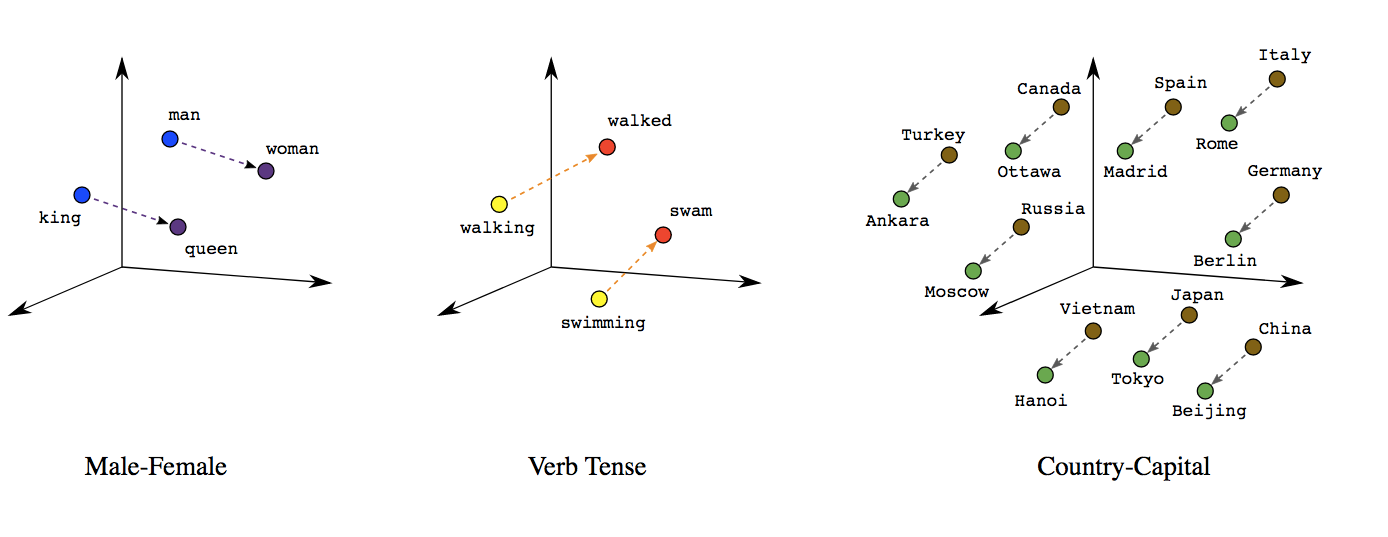

# Embeddings visualization

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval

# Sample datas
filter = datas.datas['status'].isin(['VALIDATED', 'GEM', 'REJECTED'])
sample = datas.datas[filter].sample(500)

# Convert to a list of lists of floats
emb_cols = [col for col in sample.columns if col.startswith('emb_')]
matrix = sample[emb_cols]

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(500, 2)

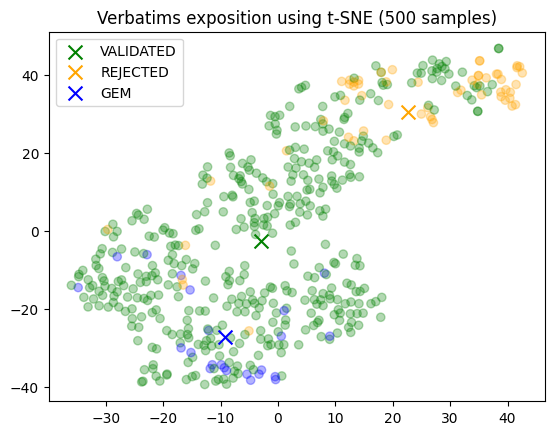

In [ ]:
# Plot embeddings
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors_list = {
    'ALERT':"red",
    'GEM':"blue",
    'TO_FIX':"yellow",
    'REJECTED':"orange",
    'VALIDATED':"green",
    'PENDING': "gray"}

x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

colors = [colors_list[status] for status in sample['status']]

plt.scatter(x, y, c=colors, alpha=0.3)
for status in sample['status'].unique():
    avg_x = np.array(x)[sample['status']==status].mean()
    avg_y = np.array(y)[sample['status']==status].mean()
    color = colors_list[status]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100, label=status, alpha=1)

plt.title(f"Verbatims exposition using t-SNE ({len(sample)} samples)")
plt.legend()
plt.show()

# SVM Classifier

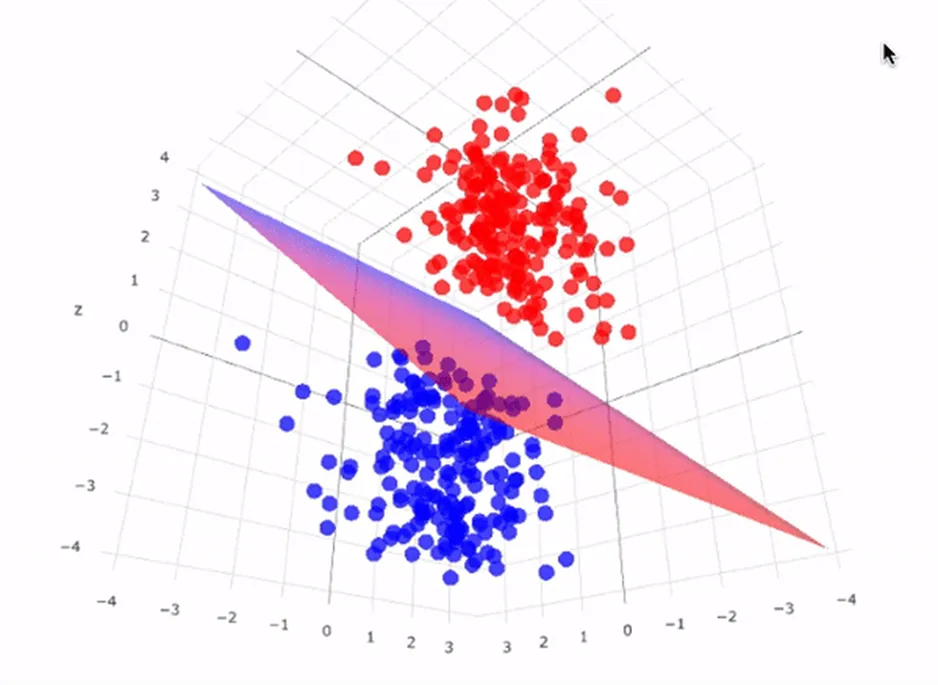

In [ ]:
%%capture
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U

In [ ]:
# Load dataset
from datasets import load_dataset
dataset = load_dataset("apprentissage-sirius/verbatims", split='all')

In [ ]:
# Create dataframe
import pandas as pd
df = dataset.to_pandas()
filter = df['status'].isin(['VALIDATED', 'GEM', 'REJECTED'])
df = df[filter]
df['label'] = df['status'].apply(lambda x: 0 if x == 'REJECTED' else 1)
features = [col for col in df.columns if col.startswith('emb_')]
X = df[features]
y = df['label']
X.sample(5)

,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,emb_768
1173,0.088228,0.169400,0.035743,-0.047393,-0.063844,0.075740,-0.121803,-0.009573,-0.157662,-0.047021,...,-0.057515,-0.133136,0.062762,0.032570,0.024582,0.014038,0.135067,-0.104604,-0.021276,-0.115030
10644,0.159258,0.211546,0.012005,-0.076013,0.015808,0.164004,-0.031569,-0.077455,-0.234379,0.173759,...,-0.087224,-0.179814,-0.091779,-0.084239,-0.103555,0.002580,0.165439,-0.067781,-0.043832,0.007821
353,0.205093,0.151861,0.166807,-0.063903,0.065437,-0.020968,-0.025239,-0.283943,-0.132797,-0.007814,...,0.111293,-0.161132,0.125800,0.125691,0.029564,0.014053,0.261575,-0.360640,-0.058786,-0.095981
1814,0.123839,0.024878,-0.001481,0.019132,0.028352,0.011527,-0.022306,-0.060733,-0.143553,0.002129,...,-0.070019,-0.071057,-0.003491,0.175953,-0.038307,-0.027310,0.250459,-0.158773,0.010259,-0.020373
4761,0.284807,0.049721,0.240292,0.026732,0.047824,0.118051,-0.080535,-0.164855,-0.203872,0.205118,...,0.093017,-0.055762,0.082071,0.011635,-0.073856,-0.008158,0.292588,-0.359247,-0.096356,0.068902


In [ ]:
y.value_counts()

,count
label,
1,11090
0,1540


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Label weights
neg_weights = len(y) / (2 * y.value_counts()[0])
pos_weights = len(y) / (2 * y.value_counts()[1])
class_weights = {0:neg_weights, 1:pos_weights}
print('Weights (pos/neg):', class_weights)

Weights (pos/neg): {0: 4.10064935064935, 1: 0.5694319206492335}


In [ ]:
# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

531 features for 99.0% threshold.


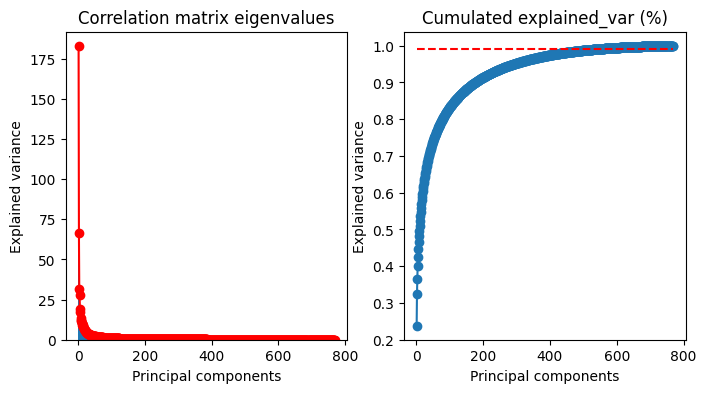

In [ ]:
# PCA optimization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pca = PCA()
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_pca = pca.fit_transform(X_train_std)

# Check variances
threshold = 0.99
variances = X_pca.var(axis=0)
total_var = variances.sum()
explained_var = variances / total_var
cum_explained_var = np.cumsum(explained_var)
fig_spectrum, axes = plt.subplots(1, 2, figsize=(8, 4))
ax_eig = axes[0]
p = X_pca.shape[1]
ax_eig.bar(range(1, p + 1), variances)
ax_eig.plot(range(1, p + 1), variances, "o-r")
ax_eig.set_title("Correlation matrix eigenvalues")
ax_eig.set_xlabel("Principal components")
ax_eig.set_ylabel("Explained variance")
ax_cum_var = axes[1]
ax_cum_var.plot(range(1, p + 1), cum_explained_var, "o-")
ax_cum_var.plot(range(1, p + 1), threshold * np.ones(p), "--r")
ax_cum_var.set_title("Cumulated explained_var (%)")
ax_cum_var.set_xlabel("Principal components")
ax_cum_var.set_ylabel("Explained variance")
fig_spectrum.show()

# Find optimal PCA features
features = 0
v = 0

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

while v < threshold:
    v = cum_sum_eigenvalues[features]
    features+=1

print(f"{features} features for {threshold*100}% threshold.")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Pipeline configuration
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=features))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train.columns),
    ],
    verbose_feature_names_out=False)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('pca',
                                                  PCA(n_components=531))]),
                                 Index(['emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8',
       'emb_9', 'emb_10',
       ...
       'emb_759', 'emb_760', 'emb_761', 'emb_762', 'emb_763', 'emb_764',
       'emb_765', 'emb_766', 'emb_767', 'emb_768'],
      dtype='object', length=768))],
                  verbose_feature_names_out=False)

In [ ]:
# Dummy classifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform")
dummy_pipeline = make_pipeline(preprocessor, dummy_clf)

# Train model
dummy_pipeline.fit(X_train, y_train)

# Evaluate model
dummy_pipeline.score(X_test, y_test)

0.5091053048297703

In [ ]:
# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    labels = sorted(set(y_test))
    print(labels)
    size = len(labels)*1.5
    fig, ax = plt.subplots(figsize=(size, size))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues",  values_format=".2f", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()

    cm = confusion_matrix(y_test, y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(size, size))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

# Model evaluation
def evaluate_model(y_test, y_pred):
    print('Accuracy: {}'.format(round(accuracy_score(y_test, y_pred), 2)))
    print('Precision: {}'.format(round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 2)))
    print('Recall: {}'.format(round(recall_score(y_test, y_pred, average='weighted', zero_division=0), 2)))
    print('F1 score: {}'.format(round(f1_score(y_test, y_pred, average='weighted', zero_division=0), 2)))
    plot_confusion_matrix(y_test, y_pred)

***Dummy Performance on test set***
Accuracy: 0.49
Precision: 0.79
Recall: 0.49
F1 score: 0.57
[0, 1]


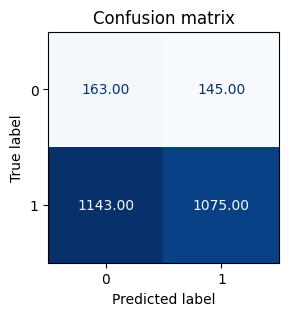

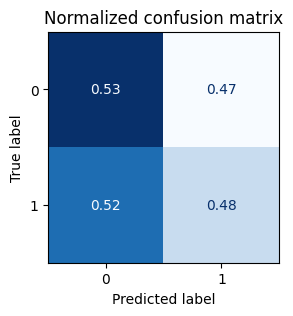

In [ ]:
# Evaluate model
y_pred = dummy_pipeline.predict(X_test)
print('***Dummy Performance on test set***')
evaluate_model(y_test, y_pred)

In [ ]:
from sklearn.svm import SVC

# SVM classifier
svc_clf = SVC(random_state=42, kernel='rbf', probability=True)
svc_pipeline = make_pipeline(preprocessor, svc_clf)

# Train model
svc_pipeline.fit(X_train, y_train)

# Model global score
svc_pipeline.score(X_test, y_test)

0.933095803642122

***SVC Performance on test set***
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1 score: 0.93
[0, 1]


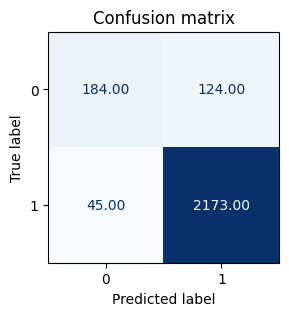

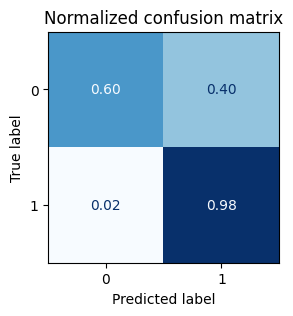

In [ ]:
# Evaluate model
y_pred = svc_pipeline.predict(X_test)
print('***SVC Performance on test set***')
evaluate_model(y_test, y_pred)

# Threshold

In [ ]:
# Default threshold (50%)
threshold = 0.5
df_test = df.loc[X_test.index][['status', 'text', 'label']]
df_test['prob'] = svc_pipeline.predict_proba(X_test)[:,1]
df_test['pred'] = (df_test['prob'] > threshold).apply(int)
df_test.sample(5)

,status,text,label,prob,pred
3652,VALIDATED,peurChangementConseil: Un salaire à la fin du ...,1,0.969766,1
3674,VALIDATED,peurChangementConseil: Je ne faisais pas d’ent...,1,0.954095,1
2762,VALIDATED,"descriptionMetierConseil: On se lève, on va tr...",1,0.973060,1
12344,REJECTED,trouverEntrepriseConseil: La rigueur,0,0.968672,1
3750,REJECTED,trouverEntrepriseConseil: E,0,0.048894,0


In [ ]:
fp = (df_test['label']==0) & (df_test['pred']==1)
fn = (df_test['label']==1) & (df_test['pred']==0)

# False positive
print('-'*33)
print('False positive (must be rejected)')
print('-'*33)
for i, row in df_test[fp].sample(10).iterrows():
    print(f"#{i} - {row['text']} | {round(row['prob']*100, 2)}%")
print('\n')

# False negative (must be validated)
print('-'*34)
print('False negative (must be validated)')
print('-'*34)
for i, row in df_test[fn].sample(10).iterrows():
    print(f"#{i} - {row['text']} | {round(row['prob']*100, 2)}%")
print('\n')

---------------------------------
False positive (must be rejected)
---------------------------------
#6325 - trouverEntrepriseConseil: Non pas de conseil  | 93.81%
#6300 - descriptionMetierConseil: Parfait  | 58.29%
#852 - avantFormationAutre: J'ai t'ai a l'IME  | 92.96%
#4186 - choseMarquanteConseil: Pour moi, en commerce, c'était d'apprendre à gérer l'humain et savoir comment parler au gens  | 96.75%
#8623 - choseMarquanteConseil: je ne peux pas t'informe | 85.64%
#12555 - differenceCollegeCfaConseil: Les cours se passe bien juste l’internat où il y a le foyer ou pas forcément tout le monde a envie de rester pendant une heure à. Rien faire et plutôt faire des cours  | 96.73%
#5277 - choseMarquanteConseil: Je sais pas honnêtement  | 66.64%
#4220 - descriptionMetierConseil: Deso j'ai la flemme  | 83.11%
#7268 - trouverEntrepriseConseil:  Très bien  | 94.17%
#3016 - descriptionMetierConseil: Travail travail | 81.48%


----------------------------------
False negative (must be validated

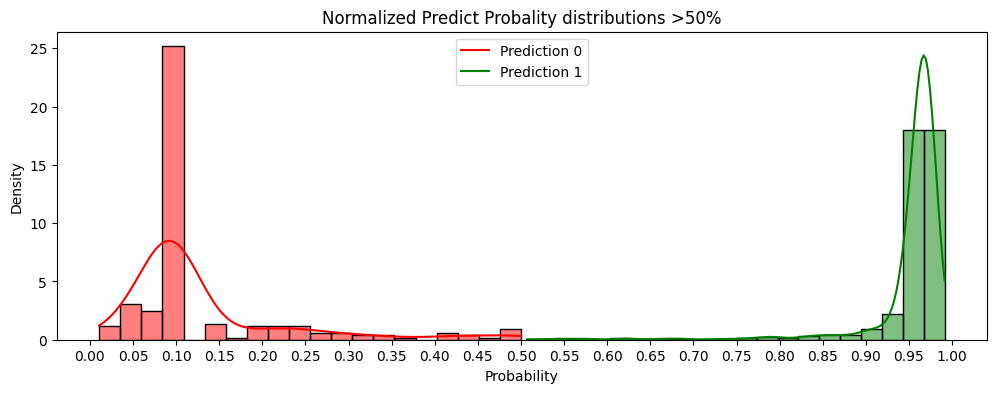

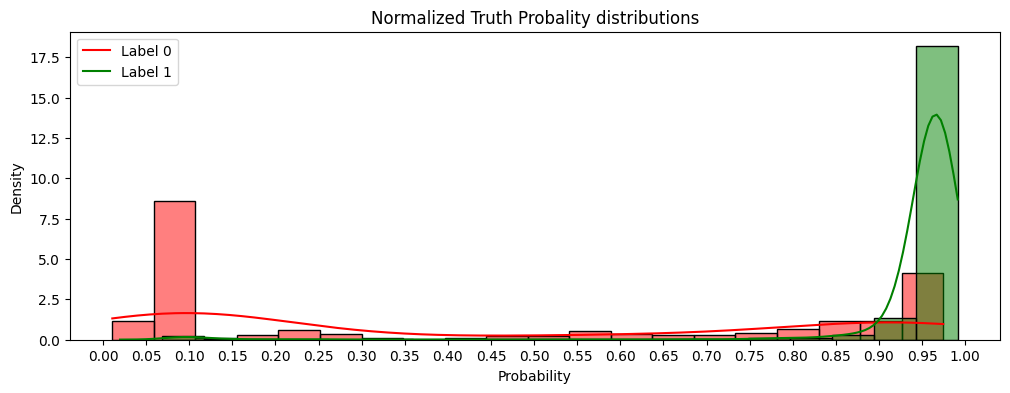

In [ ]:
# Predict density distribution (50%)
plt.figure(figsize=(12,4))
prob_0 = df_test[df_test['pred']==0]['prob']
prob_1 = df_test[df_test['pred']==1]['prob']
sns.histplot(prob_0, bins=20, stat='density', kde=True, color='red', edgecolor='black', label='0')
sns.histplot(prob_1, bins=20, stat='density', kde=True, color='green', edgecolor='black', label='1')
plt.title("Normalized Predict Probality distributions >50%")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend(['Prediction 0', 'Prediction 1'])
plt.xticks(np.arange(0, 1.05, step=0.05))
plt.show()

# Truth density distribution
plt.figure(figsize=(12,4))
prob_0 = df_test[df_test['label']==0]['prob']
prob_1 = df_test[df_test['label']==1]['prob']
sns.histplot(prob_0, bins=20, stat='density', kde=True, color='red', edgecolor='black', label='0')
sns.histplot(prob_1, bins=20, stat='density', kde=True, color='green', edgecolor='black', label='1')
plt.title("Normalized Truth Probality distributions")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend(['Label 0', 'Label 1'])
plt.xticks(np.arange(0, 1.05, step=0.05))
plt.show()

## Threshold trade off

In [ ]:
# Percentile with <10% false positive
error = 10
np.percentile(prob_0, q=100-error)

0.9523627838296412

In [ ]:
# Accuracy with <10% false positive
sum(prob_1>0.9523627838296412)/len(prob_1)

0.8074842200180342

In [ ]:
# Adjust validation threshold
threshold = 0.9523627838296412
df_test = df.loc[X_test.index][['status', 'text', 'label']]
df_test['prob'] = svc_pipeline.predict_proba(X_test)[:,1]
df_test['pred'] = (df_test['prob'] > threshold).apply(int)
df_test.sample(5)

,status,text,label,prob,pred
233,VALIDATED,peurChangementConseil: Non,1,0.094847,0
12344,REJECTED,trouverEntrepriseConseil: La rigueur,0,0.968672,1
11738,VALIDATED,choseMarquanteConseil: Il suffit souvent d’êtr...,1,0.967297,1
10514,VALIDATED,descriptionMetierConseil: J’apprends a etre da...,1,0.966843,1
11623,VALIDATED,trouverEntrepriseConseil: Postule dans toute l...,1,0.973325,1


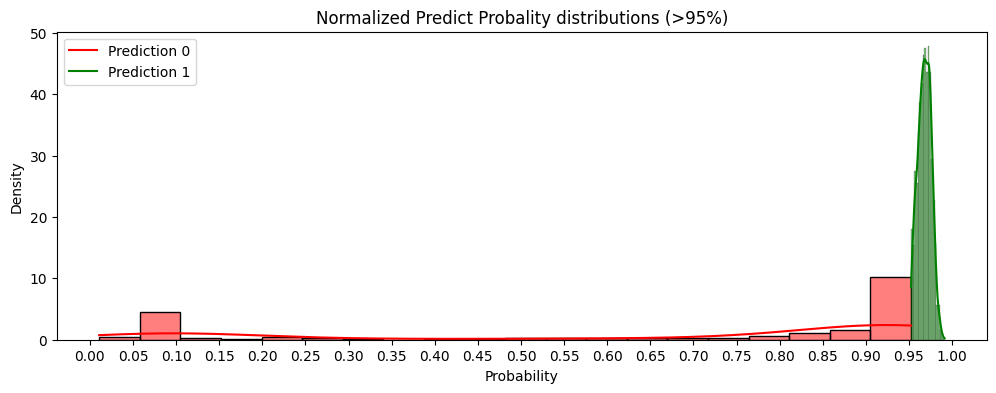

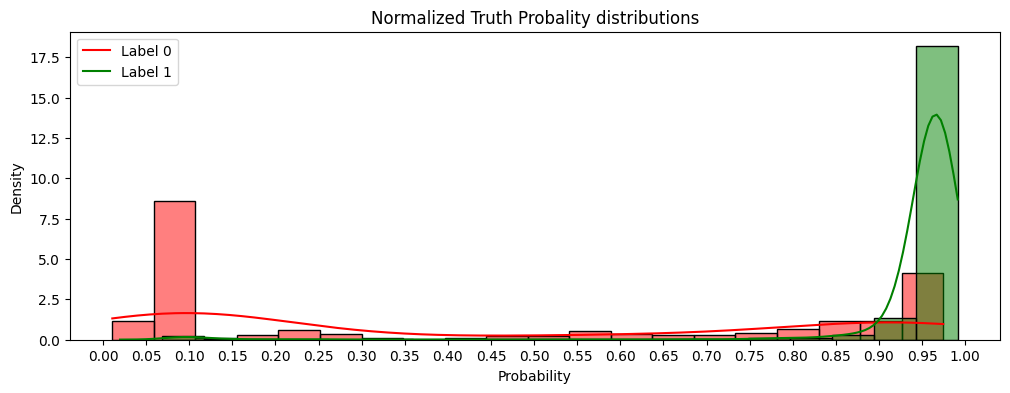

In [ ]:
# Prediction density distribution (>95%)
plt.figure(figsize=(12,4))
prob_0 = df_test[df_test['pred']==0]['prob']
prob_1 = df_test[df_test['pred']==1]['prob']
sns.histplot(prob_0, bins=20, stat='density', kde=True, color='red', edgecolor='black', label='0')
sns.histplot(prob_1, bins=20, stat='density', kde=True, color='green', edgecolor='black', label='1')
plt.title("Normalized Predict Probality distributions (>95%)")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend(['Prediction 0', 'Prediction 1'])
plt.xticks(np.arange(0, 1.05, step=0.05))
plt.show()

# Truth density distribution
plt.figure(figsize=(12,4))
prob_0 = df_test[df_test['label']==0]['prob']
prob_1 = df_test[df_test['label']==1]['prob']
sns.histplot(prob_0, bins=20, stat='density', kde=True, color='red', edgecolor='black', label='0')
sns.histplot(prob_1, bins=20, stat='density', kde=True, color='green', edgecolor='black', label='1')
plt.title("Normalized Truth Probality distributions")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend(['Label 0', 'Label 1'])
plt.xticks(np.arange(0, 1.05, step=0.05))
plt.show()

Accuracy: 0.82
Precision: 0.91
Recall: 0.82
F1 score: 0.85
[0, 1]


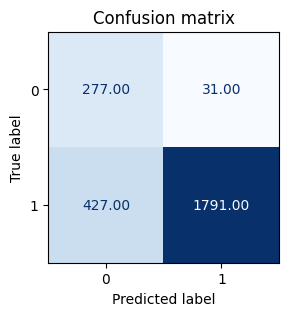

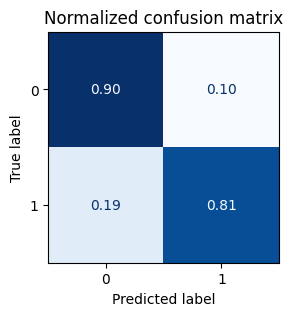

In [ ]:
evaluate_model(df_test['label'], df_test['pred'])

In [ ]:
# Check results
fp = (df_test['label']==0) & (df_test['pred']==1)
fn = (df_test['label']==1) & (df_test['pred']==0)

# False positive
print('-'*33)
print('False positive (must be rejected)')
print('-'*33)
for i, row in df_test[fp].sample(10).iterrows():
    print(f"#{i} - {row['text']} | {round(row['prob']*100, 2)}%")
print('\n')

# False negative (must be validated)
print('-'*34)
print('False negative (must be validated)')
print('-'*34)
for i, row in df_test[fn].sample(10).iterrows():
    print(f"#{i} - {row['text']} | {round(row['prob']*100, 2)}%")
print('\n')

---------------------------------
False positive (must be rejected)
---------------------------------
#5501 - choseMarquanteConseil: Rien du tout j'aime la découverte  | 97.03%
#6350 - differenceCollegeCfaConseil: C’est cool  | 97.18%
#12555 - differenceCollegeCfaConseil: Les cours se passe bien juste l’internat où il y a le foyer ou pas forcément tout le monde a envie de rester pendant une heure à. Rien faire et plutôt faire des cours  | 96.73%
#12168 - peurChangementConseil: Le fais que je n'étais pas en apprentissage et que j'étais toujours en cours ou en stage  | 97.05%
#5571 - trouverEntrepriseConseil: Appelle au tel et demande des rdv | 95.75%
#7943 - trouverEntrepriseConseil: Être présentable  | 96.03%
#12618 - differenceCollegeCfaConseil: Sa se passe bien apart des imbécile qui font le bordek en cours  | 95.89%
#12327 - peurChangementConseil: Tu as 5 semaine de congé payer pas ans  | 97.09%
#5111 - choseMarquanteConseil: reste ton cul sur la chaise si ta peur de travailler  | 9

# Generalizing approach

## Build datasets

In [1]:
%%capture
!pip install datasets

In [3]:
# Load dataset
from datasets import load_dataset
import pandas as pd
from google.colab import userdata
import os
os.environ['SIRIUS_HF_TOKEN'] = userdata.get('SIRIUS_HF')

dataset = load_dataset("apprentissage-sirius/verbatims", split='all')
df = dataset.to_pandas()

train-00000-of-00001.parquet:   0%|          | 0.00/53.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12770 [00:00<?, ? examples/s]

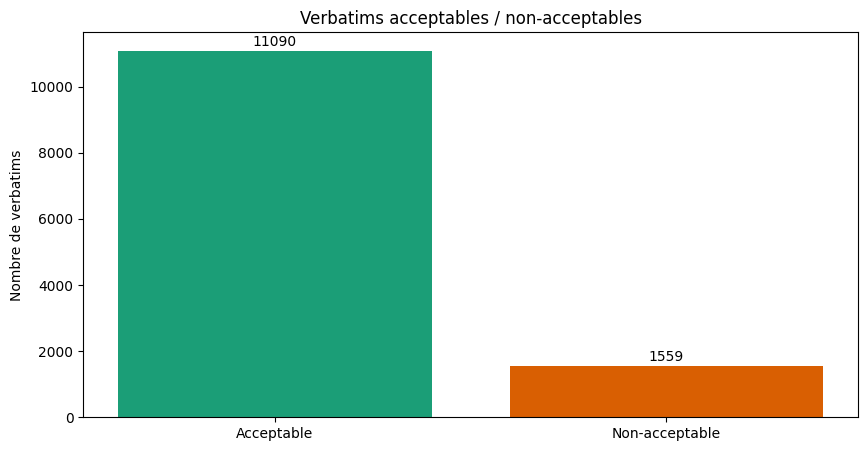

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

[Done] Valid dataset exported to: apprentissage-sirius/verbatims-valid.


In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
from datasets import Dataset

# Valid dataset
filter = df['status'] == 'PENDING'
valid_df = df[~filter].copy()
valid_df['label'] = [int(status in ['VALIDATED', 'GEM']) for status in valid_df['status']]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(['Acceptable', 'Non-acceptable'], valid_df['label'].value_counts(), align='center', color=sns.palettes.mpl_palette('Dark2'))
plt.title("Verbatims acceptables / non-acceptables")
plt.ylabel('Nombre de verbatims')
plt.bar_label(bars, padding=1)
plt.show()

# Push to hub
valid_dataset = Dataset.from_pandas(valid_df)
repo = "apprentissage-sirius/verbatims-valid"
valid_dataset.push_to_hub(repo, private=True, token=os.environ['SIRIUS_HF_TOKEN'])
print(f"[Done] Valid dataset exported to: {repo}.")

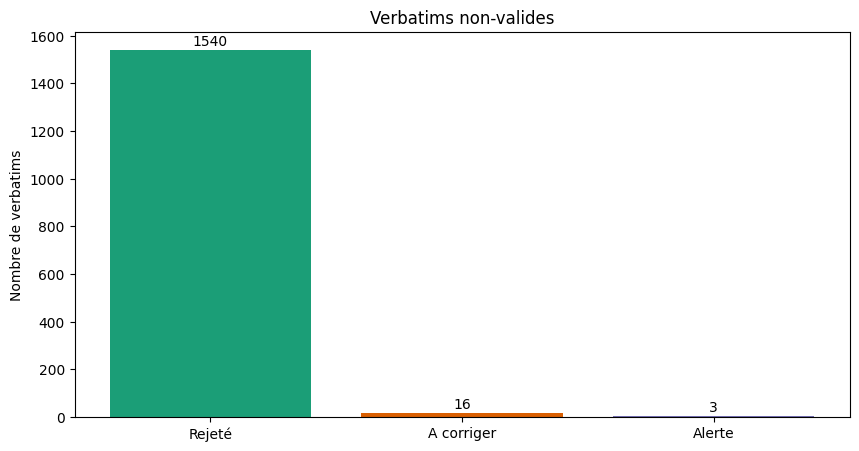

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/28.8k [00:00<?, ?B/s]

[Done] Unvalid dataset exported to: apprentissage-sirius/verbatims-unvalid.


In [24]:
# Unvalid dataset
filter = df['status'].isin(['PENDING', 'VALIDATED', 'GEM'])
unvalid_df = df[~filter].copy()
unvalid_df['label'] = unvalid_df['status']

from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(['Rejeté', 'A corriger', 'Alerte'], unvalid_df['label'].value_counts(), align='center', color=sns.palettes.mpl_palette('Dark2'))
plt.title("Verbatims non-valides")
plt.ylabel('Nombre de verbatims')
plt.bar_label(bars, padding=1)
plt.show()

# Push to hub
unvalid_dataset = Dataset.from_pandas(unvalid_df)
repo = "apprentissage-sirius/verbatims-unvalid"
unvalid_dataset.push_to_hub(repo, private=True, token=os.environ['SIRIUS_HF_TOKEN'])
print(f"[Done] Unvalid dataset exported to: {repo}.")

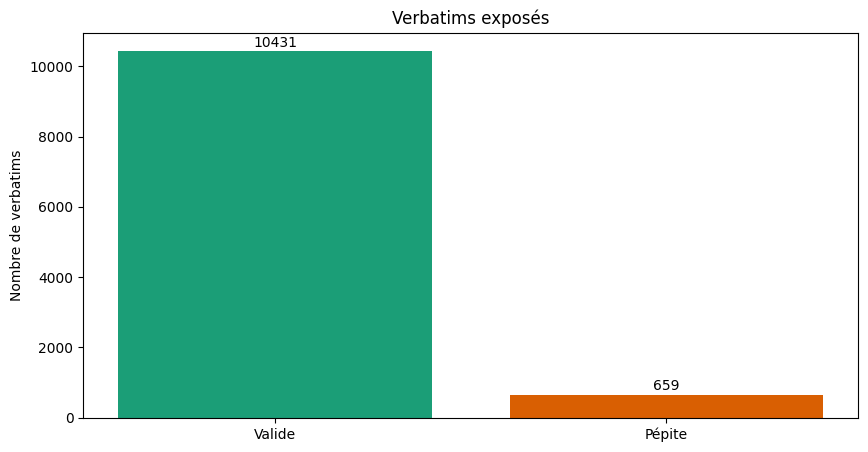

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/28.8k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


[Done] Gem dataset exported to: apprentissage-sirius/verbatims-gem.


In [26]:
# Gem dataset
filter = df['status'].isin(['VALIDATED', 'GEM'])
gem_df = df[filter].copy()
gem_df['label'] = gem_df['status']

from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(['Valide', 'Pépite'], gem_df['label'].value_counts(), align='center', color=sns.palettes.mpl_palette('Dark2'))
plt.title("Verbatims exposés")
plt.ylabel('Nombre de verbatims')
plt.bar_label(bars, padding=1)
plt.show()

gem_dataset = Dataset.from_pandas(gem_df)
repo = "apprentissage-sirius/verbatims-gem"
gem_dataset.push_to_hub(repo, private=True, token=os.environ['SIRIUS_HF_TOKEN'])
print(f"[Done] Gem dataset exported to: {repo}.")

## Push models to HF

In [28]:
# Dependencies
%%capture
!pip install datasets
!pip install accelerate -U
!pip install skops
!pip install huggingface_hub
!pip install scikit-learn==1.5.1

In [3]:
# Deploy model
import pickle as pickle
from pathlib import Path
from tempfile import mkdtemp, mkstemp
import sklearn
from skops import hub_utils
from skops.card import Card, metadata_from_config
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from huggingface_hub import HfApi
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

def train_model(dataset):
    # Load dataset
    print('- Load dataset...')
    ds = load_dataset(dataset, split='all')

    # Create training dataframe
    train_df = ds.to_pandas()
    # features = ['avg_' + str(i+1) for i in range(768)] + ['sum_' + str(i+1) for i in range(768)] + ['max_' + str(i+1) for i in range(768)]
    features = ['emb_' + str(i+1) for i in range(768)]
    label_df = train_df['label']
    feat_df = train_df[features]

    # Split dataset
    print("- Split dataset...")
    X_train, X_test, y_train, y_test = train_test_split(feat_df, label_df, test_size=0.2, random_state=42, shuffle=True, stratify=label_df)

    # PCA optimization
    print("- PCA features optimization...")
    pca = PCA()
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_pca = pca.fit_transform(X_train_std)

    # Find optimal PCA features
    threshold = 0.95
    features = 0
    v = 0
    exp_var_pca = pca.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    while v < threshold:
        v = cum_sum_eigenvalues[features]
        features+=1

    # Pipeline configuration
    print("- Configure training pipeline...")
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=features))
        ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, feat_df.columns),
        ],
        verbose_feature_names_out=False)

    # SVM classifier
    print("- Train SVM classifier...")
    clf = SVC(random_state=42, kernel='rbf', probability=True)
    pipeline = make_pipeline(preprocessor, clf)
    pipeline.fit(X_train, y_train)

    return (pipeline, X_test, y_test)

def export_model(model, X_test, y_test, repo_id, token):
    print(f"- Save model locally...")
    _, pkl_name = mkstemp(prefix="skops-", suffix=".pkl")

    with open(pkl_name, mode="bw") as f:
        pickle.dump(model, file=f)

    local_repo = mkdtemp(prefix="skops-")

    hub_utils.init(
        model=pkl_name,
        requirements=[f"scikit-learn={sklearn.__version__}"],
        dst=local_repo,
        task="text-classification",
        data=["", ""]
    )

    # Create model card
    print(f"- Create model card...")
    model_card = Card(model, metadata=metadata_from_config(Path(local_repo)))

    model_card.metadata.license = "mit"
    limitations = "This model is not ready to be used in production."
    model_description = (
        "This is a `Support Vector Classifier` model trained on SIRIUS dataset."
        "As input, the model takes text embeddings encoded with camemberta-v2 (768 tokens)"
    )
    model_card_authors = "huynhdoo"
    citation_bibtex = "**BibTeX**\n\n```\n@inproceedings{...,year={2024}}\n```"
    get_started_code = (
        "import pickle as pickle\nwith open(pkl_filename, 'rb') as file:\npipe = pickle.load(file)"
    )
    model_card.add(
        **{
            "Citation": citation_bibtex,
            "Model Card Authors": model_card_authors,
            "Model description": model_description,
            "Model description/Intended uses & limitations": limitations,
            "get_started_code":get_started_code,
        }
    )

    # Add metrics to model card
    print(f"- Add metrics to model card...")
    y_pred = model.predict(X_test)

    eval_descr = (
        "The model is evaluated on test data using accuracy and F1-score with "
        "weighted average."
    )
    model_card.add(**{"Model description/Evaluation Results": eval_descr})
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    model_card.add_metrics(**{"accuracy": accuracy, "f1 score": f1})

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
    disp.figure_.savefig(Path(local_repo) / "confusion_matrix.png")
    model_card.add_plot(
        **{"Model description/Evaluation Results/Confusion Matrix": "confusion_matrix.png"}
    )

    # Save model card
    print(f"- Save model card...")
    model_card.save(Path(local_repo) / "README.md")

    # Delete previous model
    print(f"- Delete previous model on HF...")
    try:
        HfApi().delete_repo(repo_id=repo_id, token=token)
    except:
        pass

    # Push model to hub
    print(f"- Push model to HF hub...")
    hub_utils.push(
        repo_id=repo_id,
        source=local_repo,
        token=token,
        commit_message="pushing model SVC with camember base embeddings",
        create_remote=True,
    )

    print(f"=> Model ready on https://huggingface.co/{repo_id}\n")

Deploying 'valid' model on 'apprentissage-sirius/verbatims-valid' dataset:
- Load dataset...
- Split dataset...
- PCA features optimization...
- Configure training pipeline...
- Train SVM classifier...
- Save model locally...
- Create model card...
- Add metrics to model card...
- Save model card...
- Delete previous model on HF...
- Push model to HF hub...


/usr/local/lib/python3.11/dist-packages/skops/hub_utils/_hf_hub.py:551: FutureWarning: Creating repos on hf.co is subject to strict rate limits now and therefore this feature is to be removed from this library in version 0.10. You can use tools directly available in the huggingface_hub library instead to create and push files.
  warnings.warn(


skops-_bg4j7qn.pkl:   0%|          | 0.00/6.77M [00:00<?, ?B/s]

=> Model ready on https://huggingface.co/apprentissage-sirius/verbatims-valid

Deploying 'unvalid' model on 'apprentissage-sirius/verbatims-unvalid' dataset:
- Load dataset...


README.md:   0%|          | 0.00/28.8k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.28M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1559 [00:00<?, ? examples/s]

- Split dataset...
- PCA features optimization...
- Configure training pipeline...
- Train SVM classifier...
- Save model locally...
- Create model card...
- Add metrics to model card...
- Save model card...
- Delete previous model on HF...
- Push model to HF hub...


/usr/local/lib/python3.11/dist-packages/skops/hub_utils/_hf_hub.py:551: FutureWarning: Creating repos on hf.co is subject to strict rate limits now and therefore this feature is to be removed from this library in version 0.10. You can use tools directly available in the huggingface_hub library instead to create and push files.
  warnings.warn(


skops-h6yz139h.pkl:   0%|          | 0.00/773k [00:00<?, ?B/s]

=> Model ready on https://huggingface.co/apprentissage-sirius/verbatims-unvalid

Deploying 'gem' model on 'apprentissage-sirius/verbatims-gem' dataset:
- Load dataset...


train-00000-of-00001.parquet:   0%|          | 0.00/47.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11090 [00:00<?, ? examples/s]

- Split dataset...
- PCA features optimization...
- Configure training pipeline...
- Train SVM classifier...
- Save model locally...
- Create model card...
- Add metrics to model card...
- Save model card...
- Delete previous model on HF...
- Push model to HF hub...


/usr/local/lib/python3.11/dist-packages/skops/hub_utils/_hf_hub.py:551: FutureWarning: Creating repos on hf.co is subject to strict rate limits now and therefore this feature is to be removed from this library in version 0.10. You can use tools directly available in the huggingface_hub library instead to create and push files.
  warnings.warn(


skops-td9v1vcw.pkl:   0%|          | 0.00/6.73M [00:00<?, ?B/s]

=> Model ready on https://huggingface.co/apprentissage-sirius/verbatims-gem



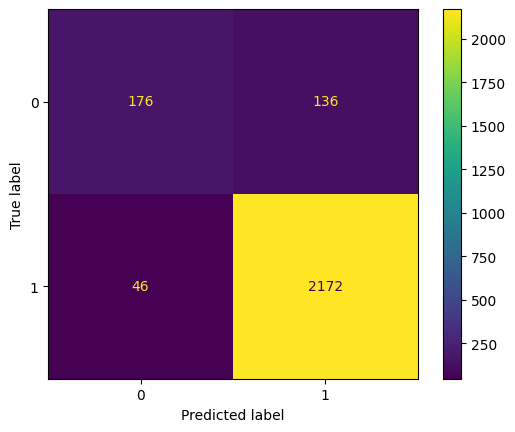

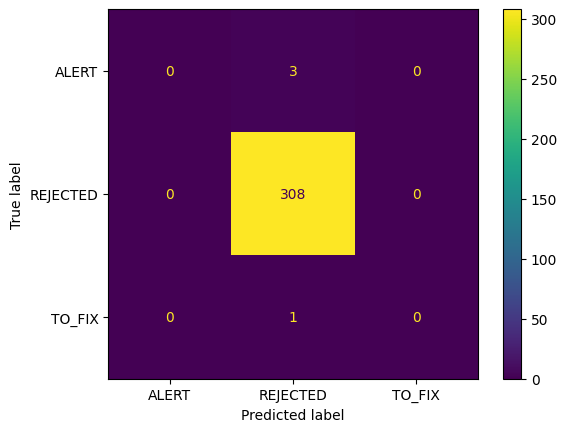

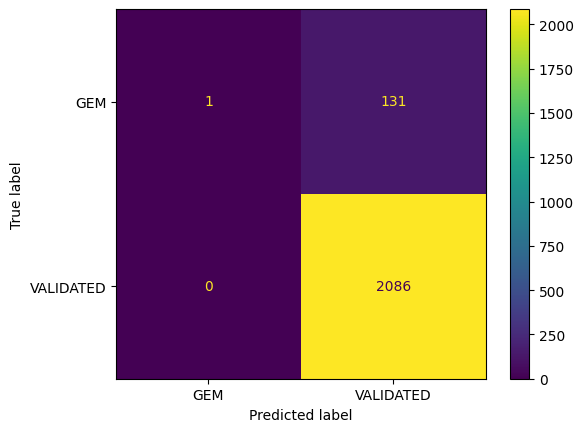

In [5]:
# Deploy all verbatims models
from google.colab import userdata

models = {
    'valid' : 'apprentissage-sirius/verbatims-valid',
    'unvalid': 'apprentissage-sirius/verbatims-unvalid',
    'gem' : 'apprentissage-sirius/verbatims-gem'
}

for model, dataset in models.items():
    title = f"Deploying '{model}' model on '{dataset}' dataset:"
    print(len(title)*'=')
    print(title)
    print(len(title)*'=')

    # Train model
    clf, X_test, y_test = train_model(dataset)

    # Export model
    export_model(clf, X_test, y_test, "apprentissage-sirius/verbatims-"+model, userdata.get('HF_TOKEN'))